In [9]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
import matplotlib.gridspec as gridspec
from itertools import product
from sklearn.model_selection import learning_curve

In [10]:
#Importing Datasets
train_df=pd.read_csv("data_train.csv")
test_df=pd.read_csv("data_test.csv")
actual_df=pd.read_csv("Copy of actual.csv")


In [11]:
#Printing Shapes
print(train_df.shape)
print(test_df.shape)
print(actual_df.shape)

(7129, 78)
(7129, 70)
(72, 2)


In [12]:
train_df.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [13]:
test_df.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [14]:
actual_df.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [15]:
unique_values = actual_df['cancer'].describe()
print(unique_values)

count      72
unique      2
top       ALL
freq       47
Name: cancer, dtype: object


# Manipulation

In [16]:
# change labels
actual_df = actual_df.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting

In [17]:
#Droping columns named 'call' from train and test datasets
cols_train = [col for col in train_df.columns if "call" in col]
cols_test = [col for col in test_df.columns if "call" in col]
train_df.drop(cols_train, axis=1, inplace=True)
test_df.drop(cols_test, axis=1, inplace=True)

**Because neither the training nor testing column names are in numerical order, we must reorder them at some point so that the labels match the corresponding data.**


In [18]:
#Creating Column indexes
train_columns = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

test_columns = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']



In [19]:
train_df = train_df.reindex(columns=train_columns)
test_df = test_df.reindex(columns=test_columns)

**Now we can simply transpose the columns and rows so that genes become features and each patient's observations occupies a single row.**

In [20]:
#To make dataset operationable
X_train = train_df.T
X_test = test_df.T

In [21]:
# Droping unnecessary columns

X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

In [22]:
# Split into train and test .

X_train = X_train.reset_index(drop=True)
y_train = actual_df[actual_df.patient <= 38].reset_index(drop=True)


X_test = X_test.reset_index(drop=True)
y_test = actual_df[actual_df.patient > 38].reset_index(drop=True)

In [23]:
# Convert from integer to float
X_train = X_train.astype(float, 64)
X_test = X_test.astype(float, 64)

In [24]:
# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
pca = PCA()
pca.fit_transform(X_train)

array([[-4.12032149e+03,  8.43574289e+03, -1.39441668e+04, ...,
         2.51106855e+03,  3.92187680e+03,  1.45323225e-11],
       [ 1.86283598e+04,  1.44078238e+04,  1.66177453e+04, ...,
        -2.30960132e+02, -1.04099055e+03,  1.45323225e-11],
       [-1.58238732e+04,  1.40484268e+04,  4.73320627e+04, ...,
         5.48675197e+02, -2.26227734e+03,  1.45323225e-11],
       ...,
       [ 6.50848905e+04, -5.49595793e+04,  1.67854688e+04, ...,
         1.18708820e+01, -1.47894896e+03,  1.45323225e-11],
       [ 4.97670530e+04, -3.81956823e+04,  2.93511865e+03, ...,
         2.66462156e+03,  7.99461277e+02,  1.45323225e-11],
       [ 1.08241948e+04, -1.68550421e+04, -9.46017931e+02, ...,
        -2.04773331e+03, -1.96917341e+03,  1.45323225e-11]])

From 7129 features to 22, not too bad.


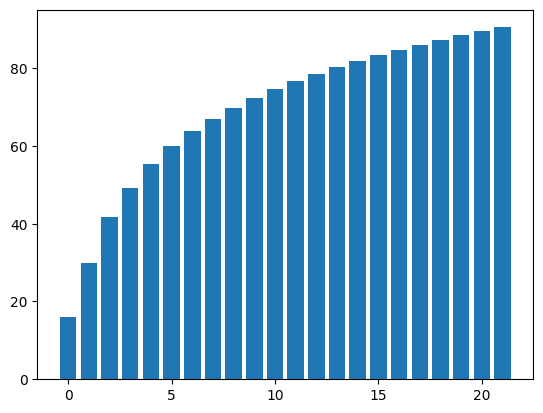

In [26]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1

print("From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

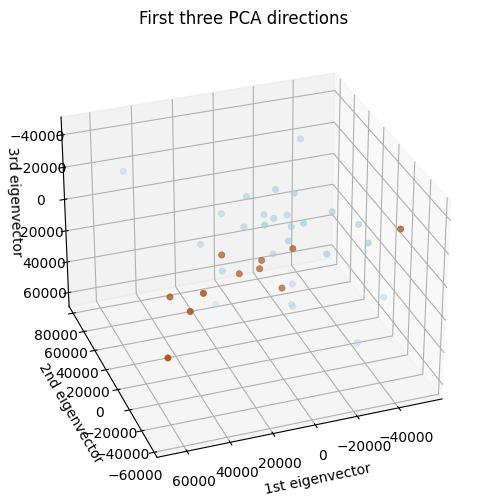

In [27]:
# Perform PCA with 3 components on the training data
pca = PCA(n_components=3).fit(X_train)
X_train_reduced = pca.transform(X_train)

# Create a new figure and 3D axes
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d', elev=-150, azim=110)

# Create a 3D scatter plot
scatter = ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c=y_train.iloc[:, 1], cmap=plt.cm.Paired, linewidths=0.5)

# Set labels and title
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# Show the plot
plt.show()


In [28]:
#for storing all accuracies
store_acc =[]

# Model Training

Support Vector Machine (SVM)

Accuracy with linear kernel: 0.987
Accuracy with rbf kernel: 0.987
Accuracy with poly kernel: 0.987
Best kernel: linear (Accuracy: 0.987)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



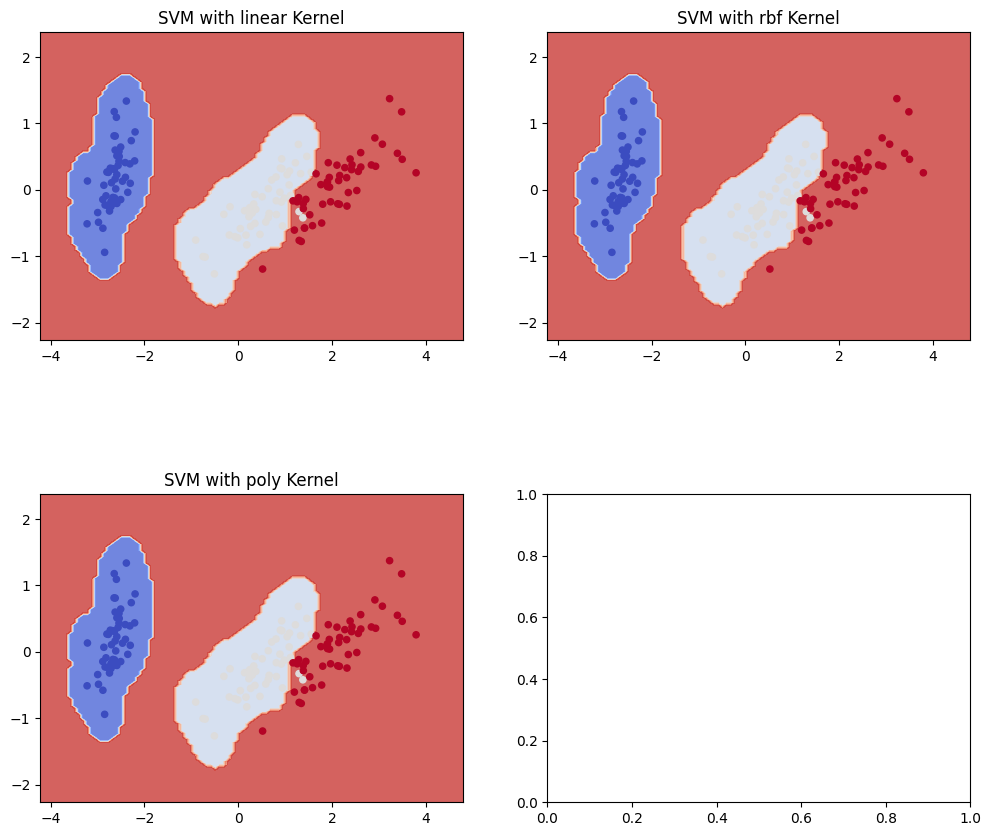

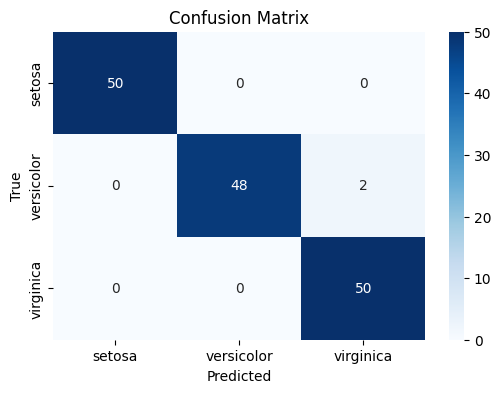

In [29]:
# Load the Iris dataset as an example
data = load_iris()
X = data.data
y = data.target

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Define the parameter grid with different values
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10],
    'kernel': ["linear", "rbf", "poly"],
    'decision_function_shape': ["ovo", "ovr"]
}

# Initialize variables to track the best kernel and its accuracy
best_kernel = None
best_accuracy = 0
best_svc = None

# Create subplots for different plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)

# Iterate over different kernels
for i, kernel in enumerate(["linear", "rbf", "poly"]):
    # Create SVM grid search classifier with the current kernel
    svm_grid = GridSearchCV(SVC(kernel=kernel), svm_param_grid, cv=3)

    # Train the classifier
    svm_grid.fit(X_pca, y)

    # Select the best SVM classifier with optimized parameters for this kernel
    best_svc = svm_grid.best_estimator_

    # Make predictions using the optimized parameters on the entire dataset
    svm_pred = best_svc.predict(X_pca)

    # Calculate accuracy for this kernel
    accuracy = accuracy_score(y, svm_pred)

    # Print the accuracy for this kernel
    print(f'Accuracy with {kernel} kernel: {accuracy:.3f}')

    # Check if this kernel has a higher accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_kernel = kernel

    # Plot the decision boundary for the current kernel
    ax = axes[i // 2, i % 2]
    xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 100),
                         np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 100))
    Z = best_svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, s=20)
    ax.set_title(f'SVM with {kernel} Kernel')

# Print the best kernel and its accuracy
print(f'Best kernel: {best_kernel} (Accuracy: {best_accuracy:.3f})')
store_acc.append(best_accuracy)
# Show classification report
svm_pred = best_svc.predict(X_pca)
print("\nClassification Report:\n", classification_report(y, svm_pred))

# Show the confusion matrix
cm_svm = confusion_matrix(y, svm_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Show all the plots
plt.show()


Random Forest

Best Parameters:
 {'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.882


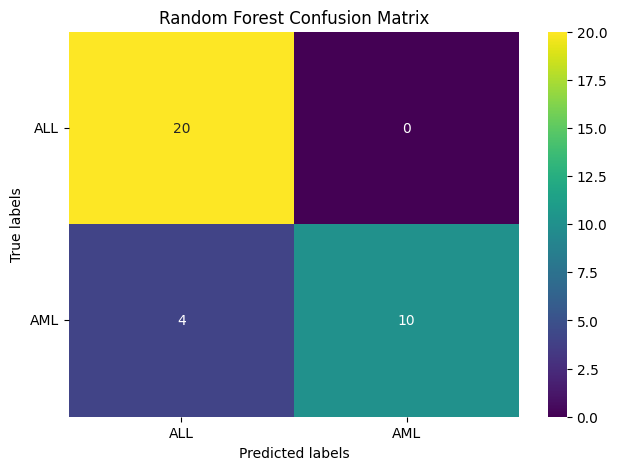

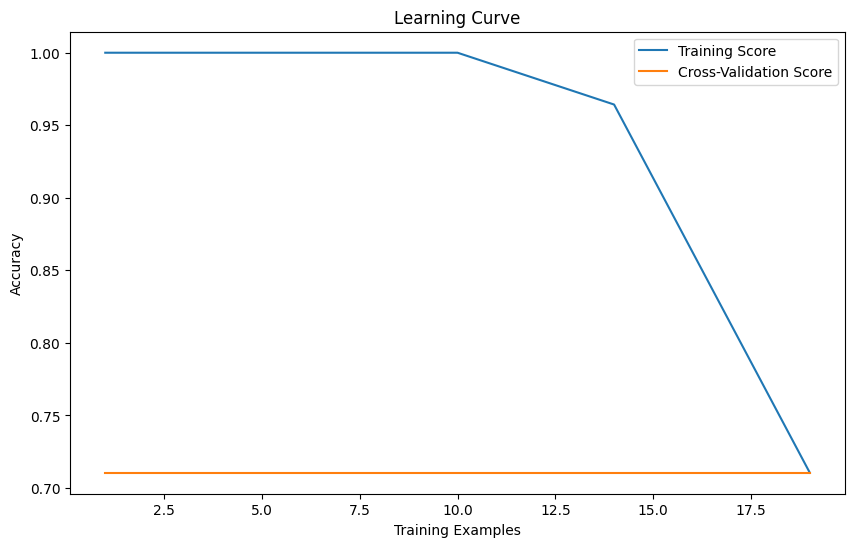

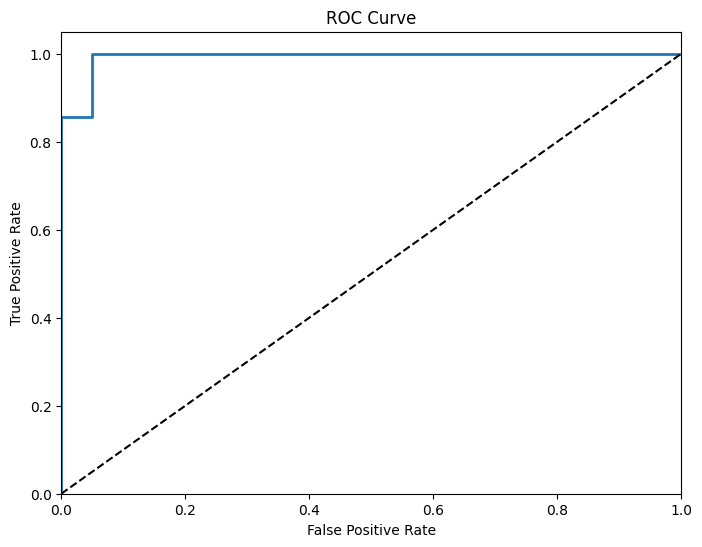

AUC: 0.9928571428571428


<Figure size 640x480 with 0 Axes>

In [30]:
# Define a smaller hyperparameter grid
rf_param_grid = {
    'n_estimators': [60, 80, 100],
    'max_features': [0.6, 0.7, 0.8],
    'min_samples_leaf': [8, 10, 12],
    'min_samples_split': [3, 5, 7]
}

# Instantiate the Random Forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object with 2-fold cross-validation
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=2, scoring='accuracy', n_jobs=4)

# Fit the model on your training data
rf_model.fit(X_train, y_train.iloc[:, 1])

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimized parameters
rf_pred = rf_model_best.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test.iloc[:, 1], rf_pred)
print('Random Forest accuracy:', round(accuracy, 3))
store_acc.append(accuracy)
# Create a confusion matrix
cm_rf = confusion_matrix(y_test.iloc[:, 1], rf_pred)

# Plot the confusion matrix
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

ax0 = plt.subplot(gs[0])
sns.heatmap(cm_rf, annot=True, ax=ax0, fmt='g', cmap='viridis')

# labels, title, and ticks
ax0.set_xlabel('Predicted labels')
ax0.set_ylabel('True labels')
ax0.set_title('Random Forest Confusion Matrix')
ax0.xaxis.set_ticklabels(labels)
ax0.yaxis.set_ticklabels(labels, rotation=360)

from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities
y_probs = rf_model_best.predict_proba(X_test)[:, 1]



# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(rf_model_best, X_train, y_train.iloc[:, 1], cv=2, n_jobs=4, train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# ROC Curve and AUC
y_probs = rf_model_best.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test.iloc[:, 1], y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate and print AUC
auc = roc_auc_score(y_test.iloc[:, 1], y_probs)
print('AUC:', auc)


plt.tight_layout()
plt.show()

Neural Network

Epoch 1/10
6/6 [==============================] - 2s 220ms/step - loss: 0.5849 - accuracy: 0.7667 - val_loss: 0.1033 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.5169 - val_accuracy: 0.7500
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.1036 - accuracy: 0.9667 - val_loss: 0.6780 - val_accuracy: 0.7500
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 8.0902e-04 - accuracy: 1.0000 - val_loss: 0.3711 - val_accuracy: 0.7500
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step
Epoch 1/10
6/6 [==============================] - 2s 71ms/step - loss: 0.4518 - accuracy: 0.8667 - val_loss: 0.3486 - val_accuracy: 0.7500
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 6.3175e-04 - accuracy: 1.0000 - val_loss: 0.2558 - val_accuracy: 0.8750
Epoch 3/10
6/6 [==============================] - 0s 17ms/step - loss: 1.6756e-04 

2/2 [==============================] - 0s 5ms/step
Epoch 1/10
6/6 [==============================] - 1s 40ms/step - loss: 1.0284 - accuracy: 0.6333 - val_loss: 3.2709e-04 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 0s 10ms/step - loss: 0.2224 - accuracy: 0.9667 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 0s 10ms/step - loss: 1.5240e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 0s 14ms/step - loss: 1.1693e-04 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 4: early stopping


2/2 [==============================] - 0s 6ms/step
Epoch 1/10
6/6 [==============================] - 1s 42ms/step - loss: 1.8154 - accuracy: 0.6333 - val_loss: 7.9039e-06 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 0s 12ms/step - loss: 0.0315 - accuracy: 1.0000 - val_loss: 4.4708e-09 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 0s 16ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 6.3974e-11 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 0s 17ms/step - loss: 7.2142e-04 - accuracy: 1.0000 - val_loss: 7.9258e-12 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 0s 22ms/step - loss: 1.3323e-04 - accuracy: 1.0000 - val_loss: 2.4869e-12 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 0s 17ms/step - loss: 9.7205e-05 - accuracy: 1.0000 - val_loss: 1.2660e-12 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 0s 19ms/step - loss: 7.0161e-

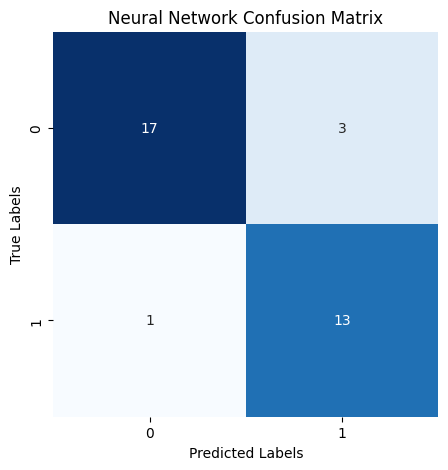

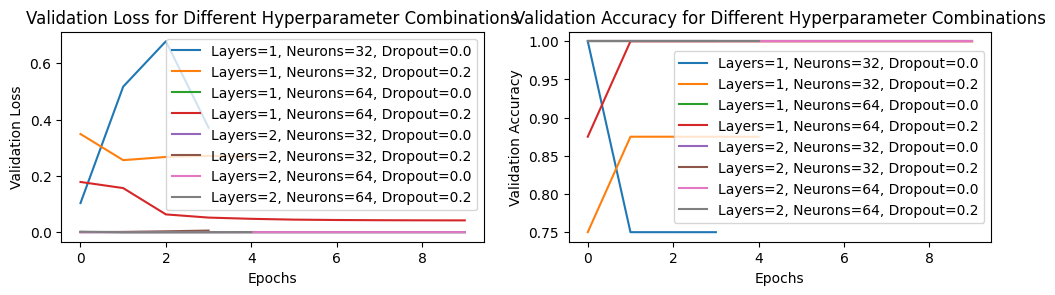

In [31]:
# Define hyperparameters to search
hyperparam_grid = {
    'hidden_layers': [1, 2],
    'neurons': [32, 64],
    'dropout_rate': [0.0, 0.2]
}

# Lists to store results
results = []

# Set a lower number of epochs for faster training
num_epochs = 10

# Loop through different hyperparameters
for params in product(hyperparam_grid['hidden_layers'], hyperparam_grid['neurons'], hyperparam_grid['dropout_rate']):
    num_hidden_layers, num_neurons, dropout_rate = params

    # Create a neural network model
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create training/validation sets (replace with your data)
    partial_X_train = X_train_scaled[:30]
    X_val = X_train_scaled[30:]
    partial_y_train = y_train.iloc[:, 1][:30]
    y_val = y_train.iloc[:, 1][30:]

    # Set up early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

    # Train the model with fewer epochs
    history = model.fit(
        partial_X_train,
        partial_y_train,
        epochs=num_epochs,
        batch_size=5,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    # Make predictions (replace with your test data)
    nn_pred = model.predict(X_test_scaled)
    nn_pred = (nn_pred > 0.5).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y_test.iloc[:, 1], nn_pred)

    # Create confusion matrix
    cm = confusion_matrix(y_test.iloc[:, 1], nn_pred)

    # Store results
    results.append({
        'hidden_layers': num_hidden_layers,
        'neurons': num_neurons,
        'dropout_rate': dropout_rate,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'history': history
    })

# Find the best hyperparameters based on accuracy
best_params = max(results, key=lambda x: x['accuracy'])
print("Best Hyperparameters:")
print(best_params)

# Create confusion matrix for the best model
best_cm = best_params['confusion_matrix']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(best_cm, annot=True, fmt='g', cmap='Blues', square=True, cbar=False)

# Labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Neural Network Confusion Matrix')

# Additional plots (e.g., training history)
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
for result in results:
    history = result['history']
    plt.plot(history.history['val_loss'], label=f"Layers={result['hidden_layers']}, Neurons={result['neurons']}, Dropout={result['dropout_rate']}")

plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss for Different Hyperparameter Combinations')

plt.subplot(2, 2, 2)
for result in results:
    history = result['history']
    plt.plot(history.history['val_accuracy'], label=f"Layers={result['hidden_layers']}, Neurons={result['neurons']}, Dropout={result['dropout_rate']}")

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy for Different Hyperparameter Combinations')

# Print final accuracy
final_accuracy = best_params['accuracy']
print(f"Final Accuracy: {final_accuracy:.4f}")
store_acc.append(final_accuracy)
plt.show()


# Result

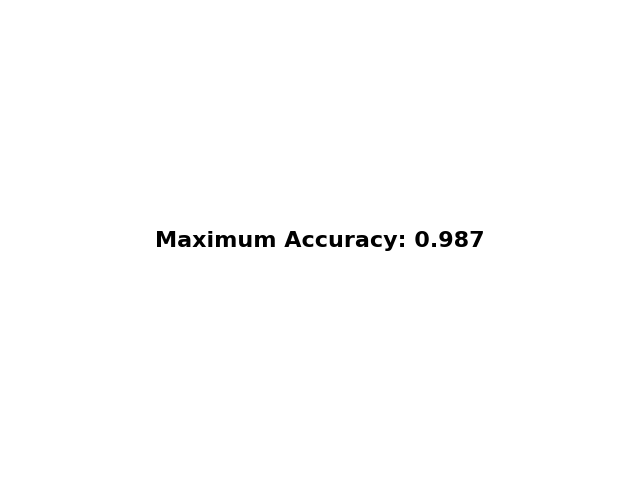

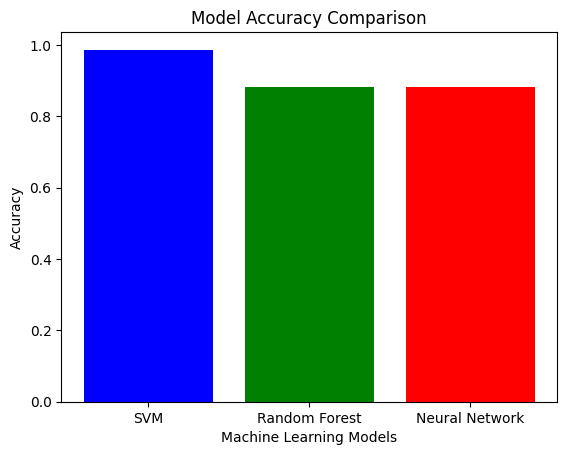

In [32]:

# Names of the machine learning models
models = ['SVM', 'Random Forest', 'Neural Network']

# Corresponding a
accuracies = store_acc

# Calculate and print the maximum accuracy
max_accuracy = max(accuracies)
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.text(0.5, 0.5, f"Maximum Accuracy: {round(max_accuracy, 3)}", fontsize=16, fontweight='bold', ha='center', va='center')
plt.axis('off')  # To remove the axes and labels
plt.show()


# Create a bar plot
plt.bar(models, accuracies, color=['blue', 'green', 'red'])

# Add labels and title
plt.xlabel('Machine Learning Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


# Display the plot
plt.show()
